In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import circularFiltering as flt
from scipy.stats import norm
import matplotlib
import glob
import os
import re
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [2]:
mu_perf = 0.5
sig_perf = 1

def objective(rMSE,mu=0,sigma=0.5):
    x = np.log(kappa_z_array)
    dx = np.diff(x)
    f = rMSE * norm.pdf(x,loc=mu,scale=sigma)
    rMSE_avg = np.sum( 1/2*(f[1:] + f[:-1] ) * dx ) # trapezoidal rule for irregular grid spacing
    return rMSE_avg

# performance of particle filter as reference (see Figure3.ipynb)
ref = 0.6912447327304075

In [3]:
preprocess = False # only set to True if you want to re-run preprocessing on data in /data_raw

path_raw = 'data_raw/figure3f/'
path_processed = 'data_processed/figure3f/'

### Figure S4 - Comparing the average performance as function of network parameters, different noise levels

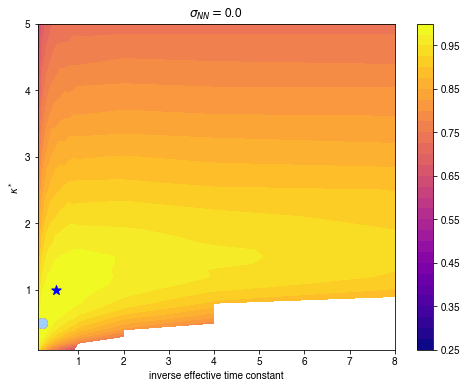

sigma=0.0
sig_to_noise=inf


/var/folders/j6/5pzpdg2x6x584m809hc4vz840000gn/T/ipykernel_7967/3190486348.py:68: RuntimeWarning: divide by zero encountered in true_divide
  sig_to_noise[ind_sig] = avg_network_activity[ idx[0] , idx[1]] / sigmaN * np.sqrt(N/2)
/var/folders/j6/5pzpdg2x6x584m809hc4vz840000gn/T/ipykernel_7967/3190486348.py:70: RuntimeWarning: divide by zero encountered in true_divide
  noretuning_sig_to_noise[ind_sig] =  avg_network_activity[ idx_ref ] / sigmaN * np.sqrt(N/2)


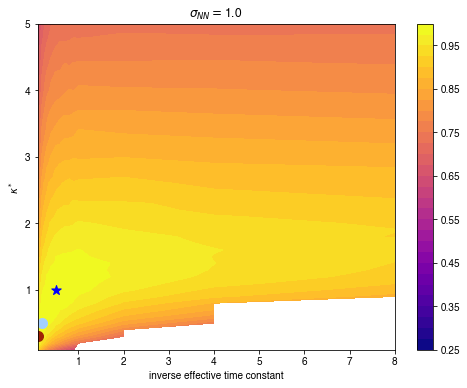

sigma=1.0
sig_to_noise=14.497152433308951


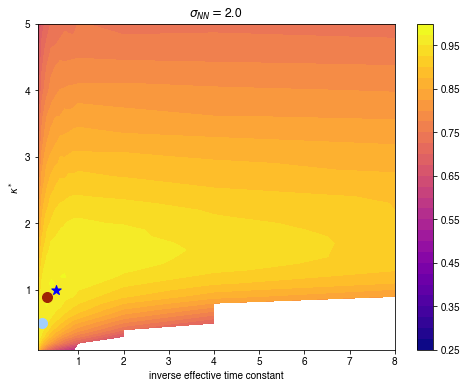

sigma=2.0
sig_to_noise=7.848664029087684


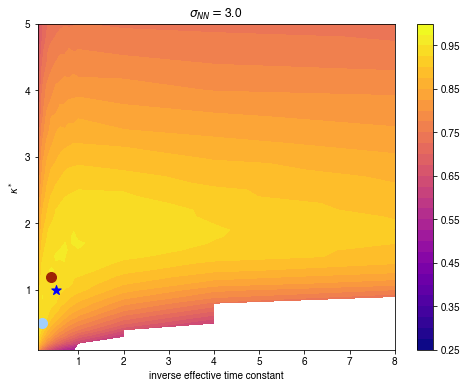

sigma=3.0
sig_to_noise=5.351546346573917


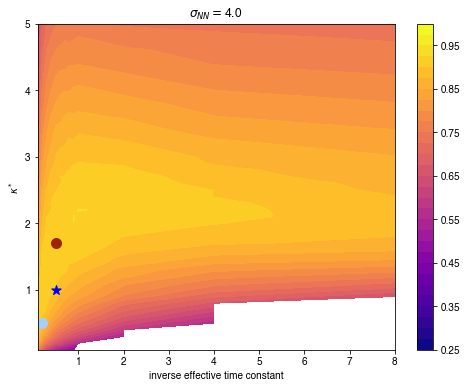

sigma=4.0
sig_to_noise=4.422658692692519


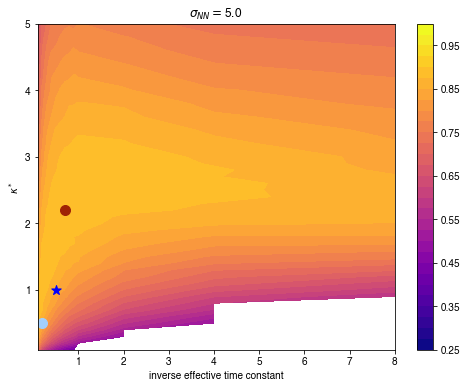

sigma=5.0
sig_to_noise=3.6200517791728006


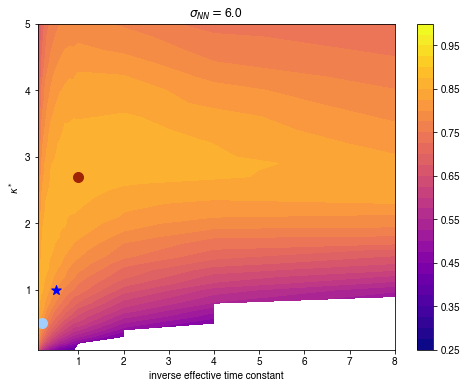

sigma=6.0
sig_to_noise=3.036124846566661


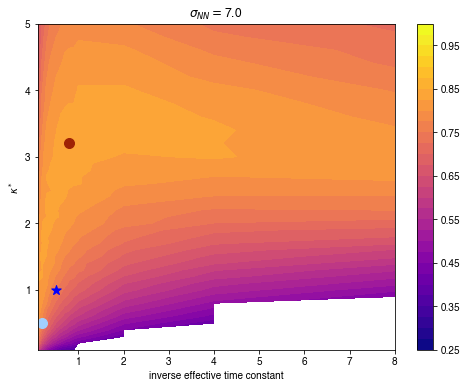

sigma=7.0
sig_to_noise=3.081069727774649


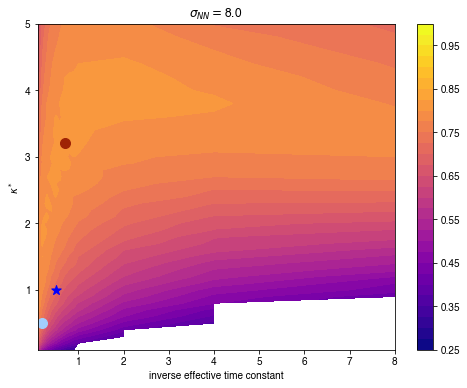

sigma=8.0
sig_to_noise=2.7192746329637645


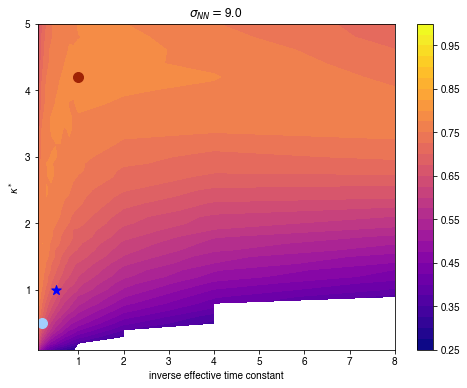

sigma=9.0
sig_to_noise=2.658450999814686


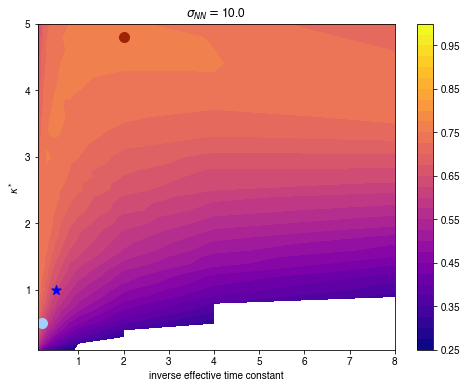

sigma=10.0
sig_to_noise=2.3252070175964668


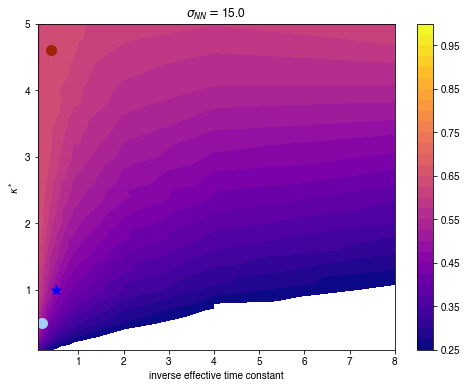

sigma=15.0
sig_to_noise=2.0532092379053295


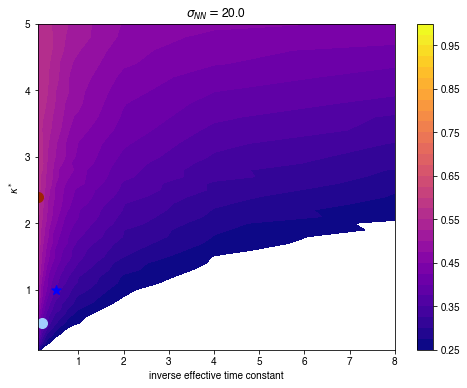

sigma=20.0
sig_to_noise=1.8497545487386557


In [8]:
kappa_star_array = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,
                            1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 
                            2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 
                            3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0])
beta_array = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1, 2 ,4 ,8])
kappa_z_array = np.array([1.e-02, 3.e-02, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01,
       7.e-01, 8.e-01, 9.e-01, 1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00,
       6.e+00, 7.e+00, 8.e+00, 9.e+00, 1.e+01, 3.e+01, 1.e+02])

N = 64

sigmaN_array = np.array([0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,15,20])
max_MSE = np.zeros(len(sigmaN_array))
noretuning_MSE = np.zeros(len(sigmaN_array))
sig_to_noise = np.zeros(len(sigmaN_array))
noretuning_sig_to_noise = np.zeros(len(sigmaN_array))

# parameters for colorbar (comparable across levels)
vmin = 0.25
vmax = 1
n = 30
levels = np.linspace(vmin,vmax,n+1)
colors = plt.cm.plasma(np.linspace(0,1,n))


for ind_sig,sigmaN in enumerate(sigmaN_array):

    if preprocess:
        MSE_array = np.nan * np.zeros((len(kappa_star_array),len(beta_array)))
        avg_network_activity = np.nan * np.zeros((len(kappa_star_array),len(beta_array)))
        for i in np.arange(len(kappa_star_array)):
            for j in np.arange(len(beta_array)):
                    filename = path_raw+"sig="+str(sigmaN)+"_k="+str(kappa_star_array[i])+"_beta="+str(beta_array[j])+".npz"
                    data = np.load(filename)
                    stats = data['stats']
                    MSE_array[i,j] = objective( stats[:,1] ,mu=mu_perf,sigma=sig_perf) 
                    avg_network_activity[i,j] = objective( stats[:,2] ,mu=mu_perf,sigma=sig_perf) 
        np.savez(path_processed+'sigma='+str(sigmaN),MSE_array=MSE_array,avg_network_activity=avg_network_activity)
    else:
        data = np.load(path_processed+'sigma='+str(sigmaN)+'.npz')
        MSE_array = data['MSE_array']
        avg_network_activity = data['avg_network_activity']

    # normalize by reference value
    MSE_array = MSE_array/ref 

    # find index of best MSE value
    idx = np.where(MSE_array == np.nanmax(MSE_array))
    if sigmaN == 0:
        idx_ref = idx

    # record parameters for best setting, and SNR value
    max_MSE[ind_sig] = np.nanmax(MSE_array)
    sig_to_noise[ind_sig] = avg_network_activity[ idx[0] , idx[1]] / sigmaN * np.sqrt(N/2)
    noretuning_MSE[ind_sig] = MSE_array[idx_ref]
    noretuning_sig_to_noise[ind_sig] =  avg_network_activity[ idx_ref ] / sigmaN * np.sqrt(N/2)

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    CS = ax.contourf(beta_array,kappa_star_array,MSE_array,levels=levels,colors=colors)
    ax.scatter(beta_array[idx[1]],kappa_star_array[idx[0]],s=100,color='xkcd:burnt red')
    ax.scatter(beta_array[idx_ref[1]],kappa_star_array[idx_ref[0]],s=100,color='xkcd:baby blue')
    ax.scatter(0.5,1,marker='*',s=100,c='blue')
    fig.colorbar(CS)
    ax.set_xlabel('inverse effective time constant')
    ax.set_ylabel(r'$\kappa^*$')
    ax.set_title(r'$\sigma_{NN}=$'+str(sigmaN))
    plt.show()

    print('sigma='+str(sigmaN))
    print('sig_to_noise='+str(sig_to_noise[ind_sig]))

### Figure 3f - Relative performance and SNR for increasing noise, with and without network retuning
Here, without retuning refers to taking the "standard" network parameters ($ \beta $ and $\kappa^*$ for best MSE in noiseless case) and network parameters with retuning for each noise level.

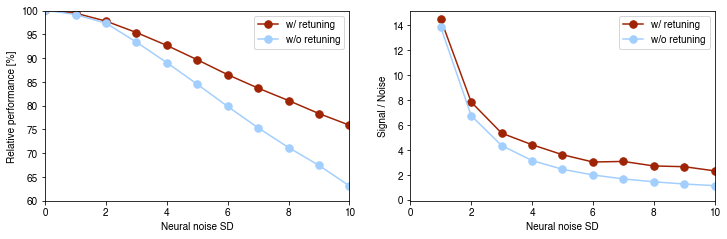

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,3.5))

# compute relative performances
rel_performance = max_MSE * 100
noretuning_MSE_rel = noretuning_MSE * 100

ax[0].plot(sigmaN_array,rel_performance,'.-',markersize=15,label='w/ retuning',color='xkcd:burnt red')
ax[0].plot(sigmaN_array,noretuning_MSE_rel,'.-',markersize=15,label='w/o retuning',color='xkcd:baby blue')
ax[0].set_xlabel(r'Neural noise SD')
ax[0].set_ylabel('Relative performance [%]')
ax[0].set_ylim([60,100])
ax[0].legend()

ax[1].plot(sigmaN_array,sig_to_noise,'.-',markersize=15,label='w/ retuning',color='xkcd:burnt red')
ax[1].plot(sigmaN_array,noretuning_sig_to_noise,'.-',markersize=15,label='w/o retuning',color='xkcd:baby blue')
ax[1].set_xlabel(r'Neural noise SD')
ax[1].set_ylabel(r'Signal / Noise')
ax[1].legend()

for i, axis in enumerate(ax):
    axis.set_xlim(0,10)

plt.show()